#Programming Assignment 2
## Dueling DQN in Cartpole Environment


### References:
1. Tutorial 5: DQN
2. Implementing the Deep-Q Network (Roderick et al.)

#### Authors:
Aditya Kumar - EP20B005

Mohammed Mustafa - EP20B025



## Installing packages and Setting up the environment

In [60]:
'''
Installing packages for rendering the game on Colab
'''
%pdb off
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

Automatic pdb calling has been turned OFF


In [61]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
from scipy.special import softmax

In [62]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('CartPole-v1', new_step_api=False)
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")


4
2
1
----
[ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
----
0
----
[ 0.01323574 -0.21745604 -0.04686959  0.22950698]
1.0
False
{}
----


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


## Type 1 Update





### Q-Network:
The neural network used as a function approximator is defined below

In [63]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e6)  # replay buffer size
HISTORY_SIZE = int(1000)
FRACTION = 0.2
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99         # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed,fc1_units=128, fc2_units=64):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        # # Define shared layers, state value stream, and advantage stream
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc_value = nn.Linear(fc1_units, fc2_units)
        self.fc_adv = nn.Linear(fc1_units, fc2_units)
        self.value = nn.Linear(fc2_units, 1)
        self.adv = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        value = F.relu(self.fc_value(x))
        adv = F.relu(self.fc_adv(x))
        value = self.value(value)
        adv = self.adv(adv)
        debug = True
        # while debug:
        #   print(type(adv))
        #   print(adv)
        #   print(adv.shape)
        #   debug = False
        adv_average = torch.mean(adv, dim=1, keepdim=True)
        q = value + adv - adv_average
        #q = value + adv - torch.max(adv, dim = 1, keepdim = True)
        return q

QNetwork1 = DuelingQNetwork

### Replay Buffer:


In [64]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, history_size, fraction, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.initial_history = deque(maxlen = history_size)
        self.fraction = fraction
        self.batch_size = batch_size
        self.history_size = history_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        if len(self) <= self.history_size: self.initial_history.append(e)


    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences1 = random.sample(self.memory, k=int(self.batch_size*(1-self.fraction)))
        ''' Randomly sample a batch from initial history '''
        experiences2 = random.sample(self.initial_history, k=int(self.batch_size*self.fraction))
        experiences = experiences1 + experiences2

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Agent Code:


In [65]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, HISTORY_SIZE, FRACTION, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        # print("state - ", state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

### Here, we present the DQN algorithm code.

In [66]:
''' Plotting subroutine '''
def plot(episode_rewards):
    plt.plot(episode_rewards)
    plt.title("Reward History For All Episodes")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward Obtained")



''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, policy="ep", eps_start=1.0, eps_end=0.01, eps_decay=0.995, \
                                                   tau_start=1.0, tau_end=0.05, tau_decay=0.995):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''
    solved = False

    eps_reward = []

    if policy=="ep":

      eps = eps_start
      for i_episode in range(1, n_episodes+1):
          # ipdb.set_trace(context=6)
          state = env.reset()
          score = 0
          for t in range(max_t):
              action = agent.act(state, eps)
              next_state, reward, done, _ = env.step(action)
              agent.step(state, action, reward, next_state, done)
              state = next_state
              score += reward
              if done:
                  break

          scores_window.append(score)
          eps_reward.append(score)

          eps = max(eps_end, eps_decay*eps)
          ''' decrease epsilon '''

          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

          if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          if np.mean(scores_window)>=195.0:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            plot(eps_reward)
            #return eps_reward, solved
          if i_episode % 300 == 0:
            plot(eps_reward)
            return eps_reward, solved

    else:
      tau = tau_start
      for i_episode in range(1, n_episodes+1):
          # ipdb.set_trace(context=6)
          state = env.reset()
          score = 0
          for t in range(max_t):
              action = agent.act(state, tau)
              next_state, reward, done, _ = env.step(action)
              agent.step(state, action, reward, next_state, done)
              state = next_state
              score += reward
              if done:
                  break

          scores_window.append(score)
          eps_reward.append(score)

          tau = max(tau_end, tau*tau_decay)
          ''' decrease tau '''

          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

          if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          if np.mean(scores_window)>=195.0:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            plot(eps_reward)
            # return eps_reward, solved
          if i_episode % 300 == 0:
            plot(eps_reward)
            return eps_reward, solved




Epsilon Greedy Run
Episode 100	Average Score: 36.09
Episode 200	Average Score: 135.59
Episode 300	Average Score: 118.62
ep_time -  0:03:13.362369



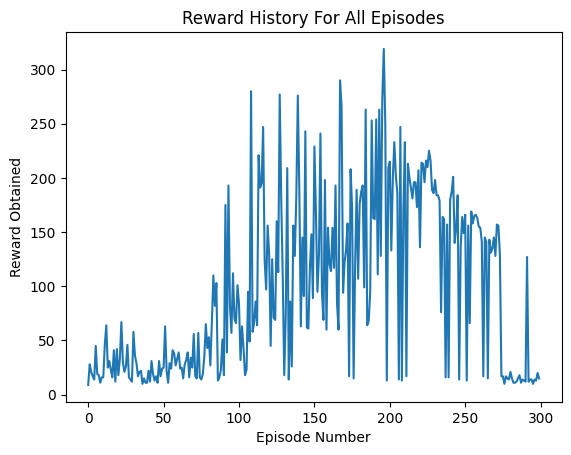

In [67]:
#Epsilon Greedy
print("Epsilon Greedy Run")
begin_time = datetime.datetime.now()
agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 42)
rew_arr, _ = dqn(policy="ep", n_episodes = 500)

time_taken = datetime.datetime.now() - begin_time
print("ep_time - ", time_taken)
print()

We observe a trend of forgetting, despite the DDQN getting maximum socres around the 200 episode mark. The paper by Roderick et al. (Implementing the Deep Q-Network) has answers about this - "A common belief for new users of DQN is that performance should fairly stably improve as more training time is given. Indeed, average Q-learning learning curves in tabular settings are typically fairly stable improvements and supervised deep-learning problems also tend have fairly steady average improvement as more data becomes available. However, it is not uncommon in DQN to have “catastrophic forgetting” in which the agent’s performance can drastically drop after a period of learning. For example, in Breakout, the DQN agent may reach a point of averaging a high score over 400, and then, after another large batch of learning, it might be averaging a score of only around 200. The solution Mnih et al. [2015] propose to this problem is to simply save the network parameters that resulted in the best test performance"

Episode 100	Average Score: 35.21
Episode 200	Average Score: 101.07
Episode 261	Average Score: 198.06
Environment solved in 261 episodes!	Average Score: 198.06
Episode 262	Average Score: 201.68
Environment solved in 262 episodes!	Average Score: 201.68
Episode 263	Average Score: 204.23
Environment solved in 263 episodes!	Average Score: 204.23
Episode 264	Average Score: 205.90
Environment solved in 264 episodes!	Average Score: 205.90
Episode 265	Average Score: 208.22
Environment solved in 265 episodes!	Average Score: 208.22
Episode 266	Average Score: 212.90
Environment solved in 266 episodes!	Average Score: 212.90
Episode 267	Average Score: 217.10
Environment solved in 267 episodes!	Average Score: 217.10
Episode 268	Average Score: 220.49
Environment solved in 268 episodes!	Average Score: 220.49
Episode 269	Average Score: 224.14
Environment solved in 269 episodes!	Average Score: 224.14
Episode 270	Average Score: 223.05
Environment solved in 270 episodes!	Average Score: 223.05
Episode 271	A

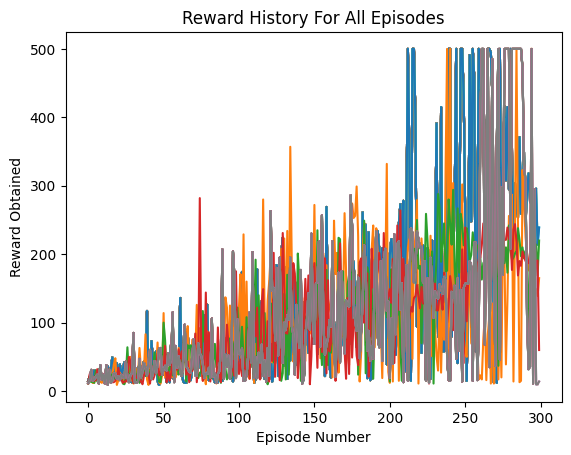

In [68]:
# # Run the training with 5 random seeds and average the results
# all_scores = []
# for seed in range(5):
#     np.random.seed(seed)
#     agent = TutorialAgent(state_shape, no_of_actions, seed)
#     scores = dqn(policy="ep", n_episodes = 500)
#     all_scores.append(scores)

# Plot the average reward history


all_scores_avg = []
seed = 0
counter = 0
while True:
  np.random.seed(seed)
  agent = TutorialAgent(state_shape, no_of_actions, seed)
  scores, solved = dqn(policy="ep", n_episodes = 500)
  all_scores_avg.append(scores)
  counter += 1
  if counter >= 5:
    break


In [69]:
# def score_corrector(master_list):
#     max_len = max([len(l) for l in master_list])
#     formatted_scores = []
#     for l in master_list:
#         holding_length = max_len - len(l)
#         for i in range(holding_length):
#             l.append(l[-1])
#         formatted_scores.append(l)
#     return formatted_scores
# new_scores = all_scores

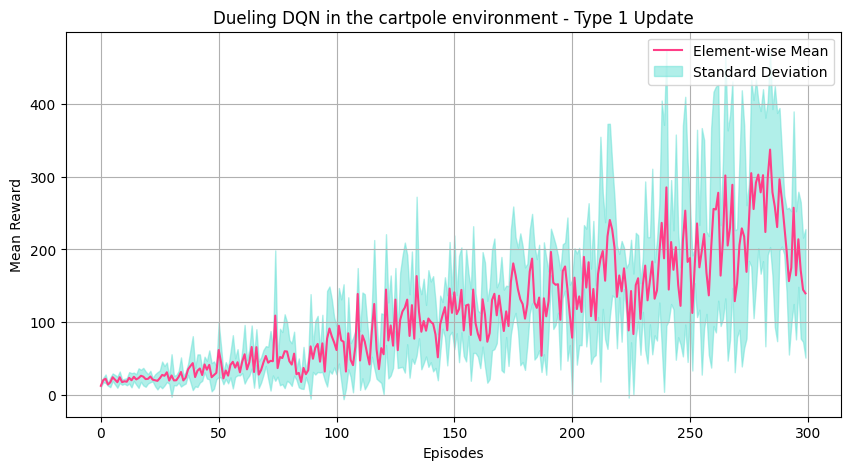

<Figure size 640x480 with 0 Axes>

In [70]:
arrays_avgUpdate = all_scores_avg.copy()
mean_values_avgUpdate = np.mean(arrays_avgUpdate, axis=0)
std_deviation_avgUpdate = np.std(arrays_avgUpdate, axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(mean_values_avgUpdate, label='Element-wise Mean', color='#FF3E87')
plt.fill_between(range(300), mean_values_avgUpdate - std_deviation_avgUpdate, mean_values_avgUpdate + std_deviation_avgUpdate, color='#64E0D5', alpha=0.5, label='Standard Deviation')
plt.title('Dueling DQN in the cartpole environment - Type 1 Update')
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("DDQN_Cartpole_Type1.png")
# # Save the plot
# plt.savefig('/app/static/uploads/mean_std_plot.png')
# plt.close()
# # Provide the path to the saved plot
# plot_path = 'https://storage.googleapis.com/llm-public-files/mpQlOqfv7v40zsboHhcU/static/uploads/mean_std_plot.png'
# plot_path



## Type 2 Update

### Setting up the Q Network

In [71]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e6)  # replay buffer size
HISTORY_SIZE = int(1000)
FRACTION = 0.2
BATCH_SIZE = 64        # minibatch size
GAMMA = 0.99         # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)

class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed,fc1_units=128, fc2_units=64):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        # # Define shared layers, state value stream, and advantage stream
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc_value = nn.Linear(fc1_units, fc2_units)
        self.fc_adv = nn.Linear(fc1_units, fc2_units)
        self.value = nn.Linear(fc2_units, 1)
        self.adv = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        value = F.relu(self.fc_value(x))
        adv = F.relu(self.fc_adv(x))
        value = self.value(value)
        adv = self.adv(adv)
        adv_average = torch.mean(adv, dim=1, keepdim=True)
        #q = value + adv - adv_average
        q = value + adv - torch.max(adv, dim = 1, keepdim = True)[0]
        return q

QNetwork1 = DuelingQNetwork

### Replay Buffer

In [72]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, history_size, fraction, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.initial_history = deque(maxlen = history_size)
        self.fraction = fraction
        self.batch_size = batch_size
        self.history_size = history_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        if len(self) <= self.history_size: self.initial_history.append(e)


    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences1 = random.sample(self.memory, k=int(self.batch_size*(1-self.fraction)))
        ''' Randomly sample a batch from initial history '''
        experiences2 = random.sample(self.initial_history, k=int(self.batch_size*self.fraction))
        experiences = experiences1 + experiences2

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Agent Code

In [73]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, HISTORY_SIZE, FRACTION, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        # print("state - ", state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

### Setting up DQN algorithm

In [74]:
''' Plotting subroutine '''
def plot(episode_rewards):
    plt.plot(episode_rewards)
    plt.title("Reward History For All Episodes")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward Obtained")



''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, policy="ep", eps_start=1.0, eps_end=0.01, eps_decay=0.995, \
                                                   tau_start=1.0, tau_end=0.05, tau_decay=0.995):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''
    solved = False

    eps_reward = []

    if policy=="ep":

      eps = eps_start
      for i_episode in range(1, n_episodes+1):
          # ipdb.set_trace(context=6)
          state = env.reset()
          score = 0
          for t in range(max_t):
              action = agent.act(state, eps)
              next_state, reward, done, _ = env.step(action)
              agent.step(state, action, reward, next_state, done)
              state = next_state
              score += reward
              if done:
                  break

          scores_window.append(score)
          eps_reward.append(score)

          eps = max(eps_end, eps_decay*eps)
          ''' decrease epsilon '''

          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

          if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          # if np.mean(scores_window)>=195.0:
          #   solved = True
          #   print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          #   plot(eps_reward)
          #   return eps_reward, solved
          if i_episode % 300 == 0:
            plot(eps_reward)
            return eps_reward, solved

    else:
      tau = tau_start
      for i_episode in range(1, n_episodes+1):
          # ipdb.set_trace(context=6)
          state = env.reset()
          score = 0
          for t in range(max_t):
              action = agent.act(state, tau)
              next_state, reward, done, _ = env.step(action)
              agent.step(state, action, reward, next_state, done)
              state = next_state
              score += reward
              if done:
                  break

          scores_window.append(score)
          eps_reward.append(score)

          tau = max(tau_end, tau*tau_decay)
          ''' decrease tau '''

          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

          if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          if np.mean(scores_window)>=195.0:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            plot(eps_reward)
            # return eps_reward, solved
          if i_episode % 300 == 0:
            plot(eps_reward)
            return eps_reward, solved




Episode 100	Average Score: 36.63
Episode 200	Average Score: 124.98
Episode 300	Average Score: 252.35
Episode 100	Average Score: 38.17
Episode 200	Average Score: 146.15
Episode 300	Average Score: 258.32
Episode 100	Average Score: 40.78
Episode 200	Average Score: 122.09
Episode 300	Average Score: 157.54
Episode 100	Average Score: 42.71
Episode 200	Average Score: 142.52
Episode 300	Average Score: 132.54
Episode 100	Average Score: 45.11
Episode 200	Average Score: 117.89
Episode 300	Average Score: 143.61


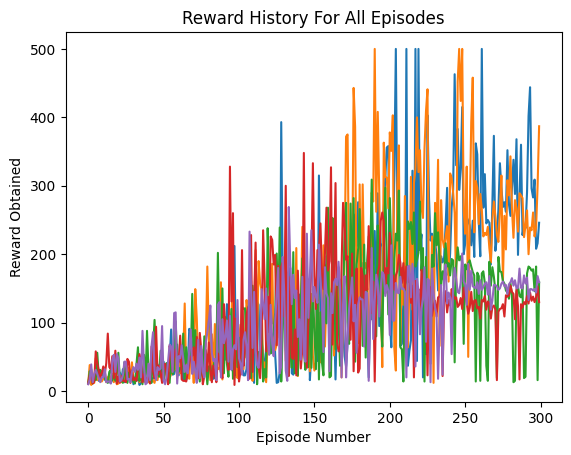

In [75]:

all_scores_max = []
seed = 0
counter = 0
while True:
  np.random.seed(seed)
  agent = TutorialAgent(state_shape, no_of_actions, seed)
  scores, solved = dqn(policy="ep", n_episodes = 500)
  all_scores_max.append(scores)
  counter += 1
  if counter >= 5:
    break

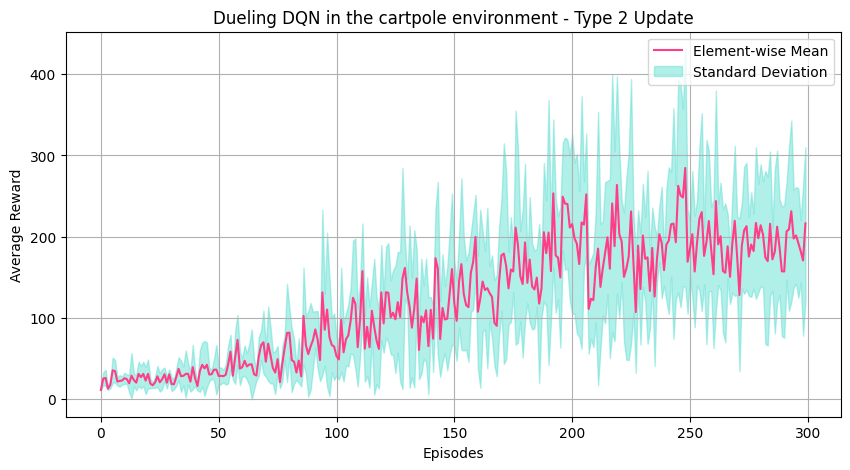

In [77]:
arrays_maxUpdate = all_scores_max.copy()
mean_values_maxUpdate = np.mean(arrays_maxUpdate, axis=0)
std_deviation_maxUpdate = np.std(arrays_maxUpdate, axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(mean_values_maxUpdate, label='Element-wise Mean', color='#FF3E87')
plt.fill_between(range(300), mean_values_maxUpdate - std_deviation_maxUpdate, mean_values_maxUpdate + std_deviation_maxUpdate, color='#64E0D5', alpha=0.5, label='Standard Deviation')
plt.title('Dueling DQN in the cartpole environment - Type 2 Update')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)
plt.show()

## Plotting the Final Figure

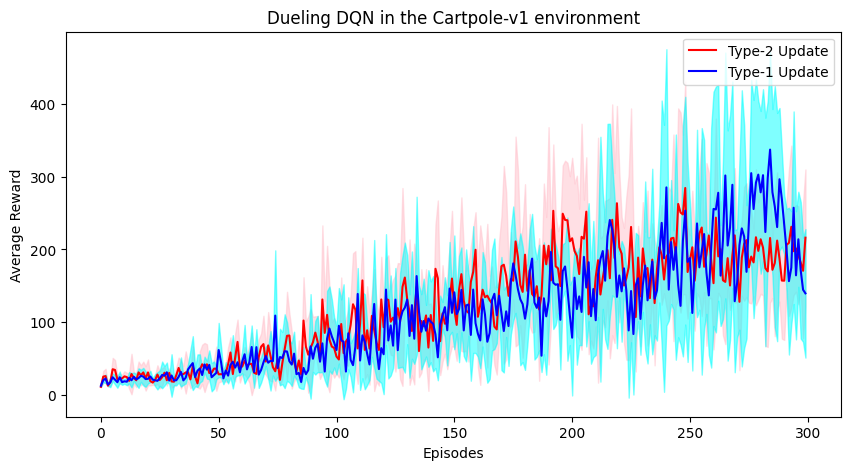

<Figure size 640x480 with 0 Axes>

In [78]:
#Plotting Final Figure
plt.figure(figsize=(10, 5))
plt.plot(mean_values_maxUpdate, label='Type-2 Update', color='red')
plt.plot(mean_values_avgUpdate, label='Type-1 Update', color='blue')
plt.fill_between(range(300), mean_values_maxUpdate - std_deviation_maxUpdate, mean_values_maxUpdate + std_deviation_maxUpdate, color='pink', alpha=0.5)
plt.fill_between(range(300), mean_values_avgUpdate - std_deviation_avgUpdate, mean_values_avgUpdate + std_deviation_avgUpdate, color='cyan', alpha=0.5)
plt.title('Dueling DQN in the Cartpole-v1 environment')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(False)
plt.show()
plt.savefig('CartpoleV1_DuelingDQN')

## Miscellaneous Experiments

Episode 100	Average Score: 41.25
Episode 200	Average Score: 133.74
Episode 300	Average Score: 129.15
Episode 100	Average Score: 42.73
Episode 200	Average Score: 117.69
Episode 300	Average Score: 142.70
Episode 100	Average Score: 42.70
Episode 200	Average Score: 136.42
Episode 300	Average Score: 168.31
Episode 100	Average Score: 41.72
Episode 200	Average Score: 145.15
Episode 300	Average Score: 161.29
Episode 100	Average Score: 43.64
Episode 200	Average Score: 135.50
Episode 300	Average Score: 123.93
Episode 100	Average Score: 42.63
Episode 200	Average Score: 119.90
Episode 300	Average Score: 183.72
Episode 100	Average Score: 40.37
Episode 200	Average Score: 105.78
Episode 300	Average Score: 135.63
Episode 100	Average Score: 36.07
Episode 200	Average Score: 112.29
Episode 300	Average Score: 158.88
Episode 100	Average Score: 42.04
Episode 200	Average Score: 113.12
Episode 300	Average Score: 166.17
Episode 100	Average Score: 38.79
Episode 200	Average Score: 128.31
Episode 300	Average Scor

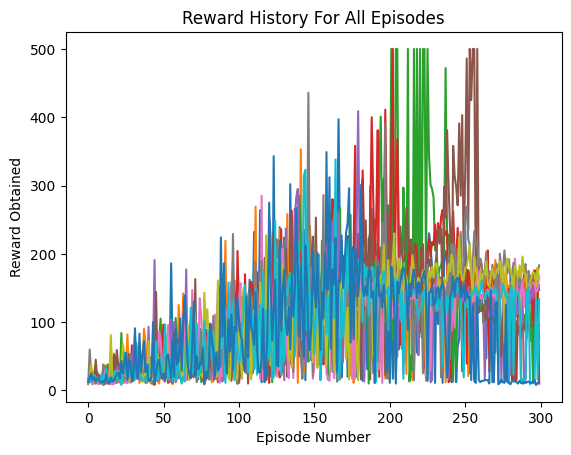

In [36]:
# allNew_scores = []
# seed = 0
# counter = 0
# while True:
#   np.random.seed(seed)
#   agent = TutorialAgent(state_shape, no_of_actions, seed)
#   scores, solved = dqn(policy="ep", n_episodes = 500)
#   allNew_scores.append(scores)
#   counter += 1
#   if counter >= 5:
#     break


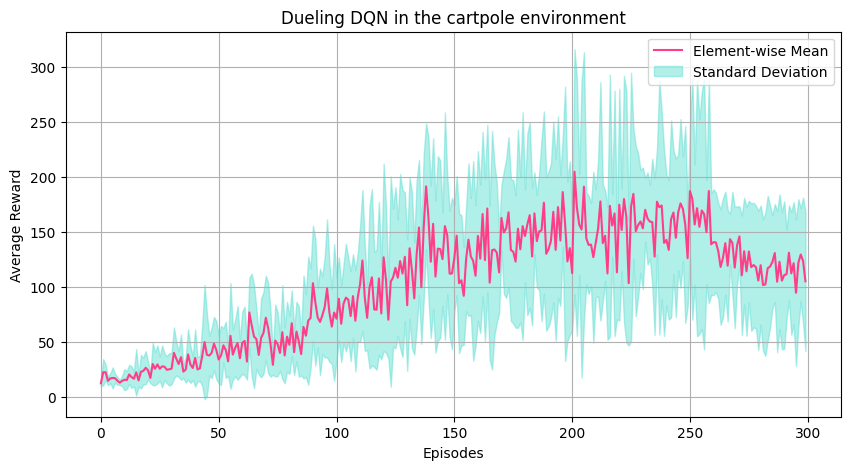

In [37]:
# arraysNew_maxUpdate = allNew_scores.copy()
# mean_valuesNew_maxUpdate = np.mean(arraysNew_maxUpdate, axis=0)
# std_deviationNew_maxUpdate = np.std(arraysNew_maxUpdate, axis=0)

# # Plotting
# plt.figure(figsize=(10, 5))
# plt.plot(mean_valuesNew_maxUpdate, label='Element-wise Mean', color='#FF3E87')
# plt.fill_between(range(300), mean_valuesNew_maxUpdate - std_deviationNew_maxUpdate, mean_valuesNew_maxUpdate + std_deviationNew_maxUpdate, color='#64E0D5', alpha=0.5, label='Standard Deviation')
# plt.title('Dueling DQN in the cartpole environment')
# plt.xlabel('Episodes')
# plt.ylabel('Average Reward')
# plt.legend()
# plt.grid(True)
# plt.show()

Episode 100	Average Score: 40.74
Episode 200	Average Score: 126.04
Episode 300	Average Score: 212.75
Episode 100	Average Score: 39.45
Episode 200	Average Score: 137.42
Episode 300	Average Score: 194.11
Episode 100	Average Score: 39.64
Episode 200	Average Score: 119.92
Episode 300	Average Score: 206.89
Episode 100	Average Score: 42.84
Episode 200	Average Score: 154.65
Episode 300	Average Score: 117.79
Episode 100	Average Score: 39.19
Episode 200	Average Score: 109.53
Episode 300	Average Score: 303.21


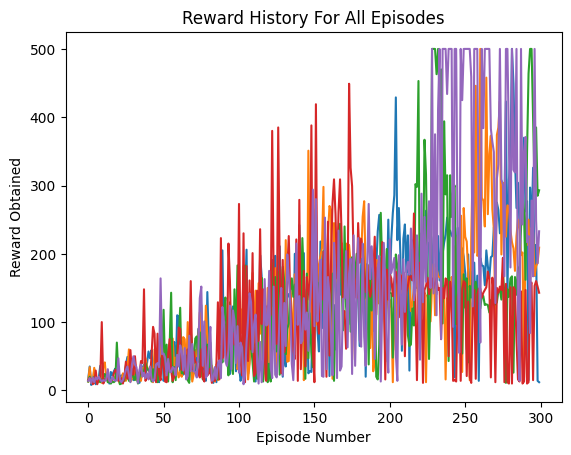

In [51]:
# allNew_scores = []
# seed = 0
# counter = 0
# while True:
#   np.random.seed(seed)
#   agent = TutorialAgent(state_shape, no_of_actions, seed)
#   scores, solved = dqn(policy="ep", n_episodes = 500)
#   allNew_scores.append(scores)
#   counter += 1
#   if counter >= 5:
#     break

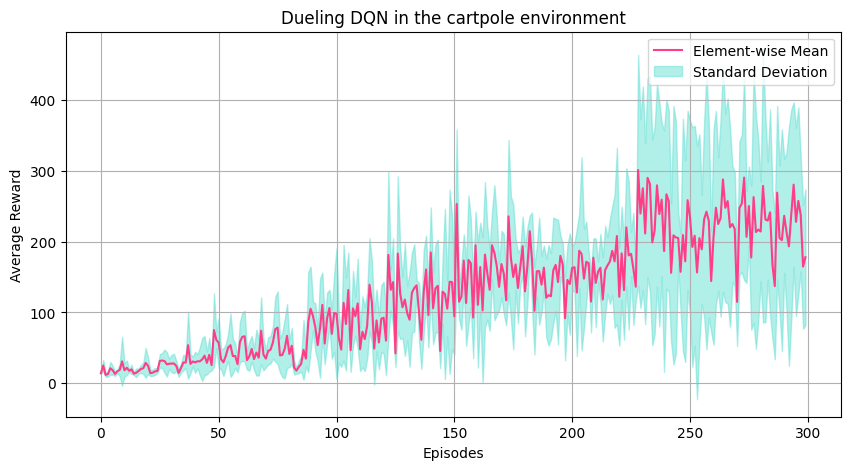

In [52]:
# arraysNew_maxUpdate = allNew_scores.copy()
# mean_valuesNew_maxUpdate = np.mean(arraysNew_maxUpdate, axis=0)
# std_deviationNew_maxUpdate = np.std(arraysNew_maxUpdate, axis=0)

# # Plotting
# plt.figure(figsize=(10, 5))
# plt.plot(mean_valuesNew_maxUpdate, label='Element-wise Mean', color='#FF3E87')
# plt.fill_between(range(300), mean_valuesNew_maxUpdate - std_deviationNew_maxUpdate, mean_valuesNew_maxUpdate + std_deviationNew_maxUpdate, color='#64E0D5', alpha=0.5, label='Standard Deviation')
# plt.title('Dueling DQN in the cartpole environment')
# plt.xlabel('Episodes')
# plt.ylabel('Average Reward')
# plt.legend()
# plt.grid(True)
# plt.show()

In [53]:
# '''
# ### Q Network & Some 'hyperparameters'

# QNetwork1:
# Input Layer - 4 nodes (State Shape) \
# Hidden Layer 1 - 128 nodes \
# Hidden Layer 2 - 64 nodes \
# Output Layer - 2 nodes (Action Space) \
# Optimizer - zero_grad()
# '''

# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# '''
# Bunch of Hyper parameters (Which you might have to tune later)
# '''
# BUFFER_SIZE = int(1e6)  # replay buffer size
# HISTORY_SIZE = int(1000)
# FRACTION = 0.1
# BATCH_SIZE = 64         # minibatch size
# GAMMA = 0.99         # discount factor
# LR = 0.001               # learning rate
# UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


# # class QNetwork1(nn.Module):

# #     def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
# #         """Initialize parameters and build model.
# #         Params
# #         ======
# #             state_size (int): Dimension of each state
# #             action_size (int): Dimension of each action
# #             seed (int): Random seed
# #             fc1_units (int): Number of nodes in first hidden layer
# #             fc2_units (int): Number of nodes in second hidden layer
# #         """
# #         super(QNetwork1, self).__init__()
# #         self.seed = torch.manual_seed(seed)
# #         self.fc1 = nn.Linear(state_size, fc1_units)
# #         self.fc2 = nn.Linear(fc1_units, fc2_units)
# #         self.fc3 = nn.Linear(fc2_units, action_size)

# #     def forward(self, state):
# #         """Build a network that maps state -> action values."""
# #         x = F.relu(self.fc1(state))
# #         x = F.relu(self.fc2(x))
# #         return self.fc3(x)

# class DuelingQNetwork(nn.Module):
#     def __init__(self, state_size, action_size, seed,fc1_units=128, fc2_units=64):
#         super(DuelingQNetwork, self).__init__()
#         self.seed = torch.manual_seed(seed)
#         # # Define shared layers, state value stream, and advantage stream
#         self.fc1 = nn.Linear(state_size, fc1_units)
#         self.fc_value = nn.Linear(fc1_units, fc2_units)
#         self.fc_adv = nn.Linear(fc1_units, fc2_units)
#         self.value = nn.Linear(fc2_units, 1)
#         self.adv = nn.Linear(fc2_units, action_size)

#     def forward(self, state):
#         x = F.relu(self.fc1(state))
#         value = F.relu(self.fc_value(x))
#         adv = F.relu(self.fc_adv(x))
#         value = self.value(value)
#         adv = self.adv(adv)
#         debug = True
#         # while debug:
#         #   print(type(adv))
#         #   print(adv)
#         #   print(adv.shape)
#         #   debug = False
#         adv_average = torch.mean(adv, dim=1, keepdim=True)
#         q = value + adv - adv_average
#         #q = value + adv - torch.max(adv, dim = 1, keepdim = True)
#         return q

# QNetwork1 = DuelingQNetwork

Episode 100	Average Score: 35.58
Episode 200	Average Score: 85.23
Episode 300	Average Score: 115.82
Episode 100	Average Score: 39.62
Episode 200	Average Score: 89.28
Episode 300	Average Score: 153.52
Episode 100	Average Score: 39.54
Episode 200	Average Score: 73.67
Episode 300	Average Score: 99.83
Episode 100	Average Score: 31.23
Episode 200	Average Score: 126.29
Episode 300	Average Score: 137.82
Episode 100	Average Score: 35.93
Episode 200	Average Score: 76.39
Episode 300	Average Score: 116.93


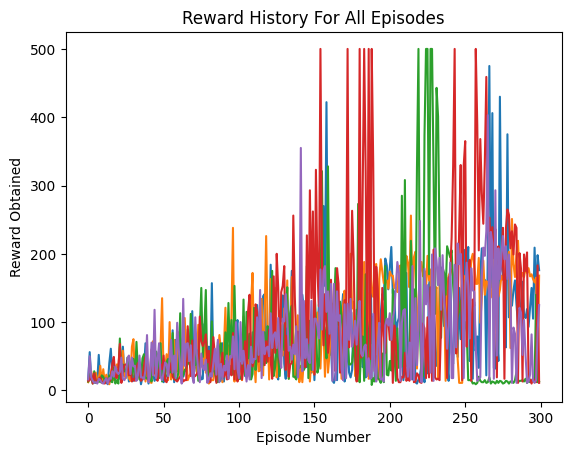

In [54]:
# allN_scores = []
# seed = 0
# counter = 0
# while True:
#   np.random.seed(seed)
#   agent = TutorialAgent(state_shape, no_of_actions, seed)
#   scores, solved = dqn(policy="ep", n_episodes = 500)
#   allN_scores.append(scores)
#   counter += 1
#   if counter >= 5:
#     break

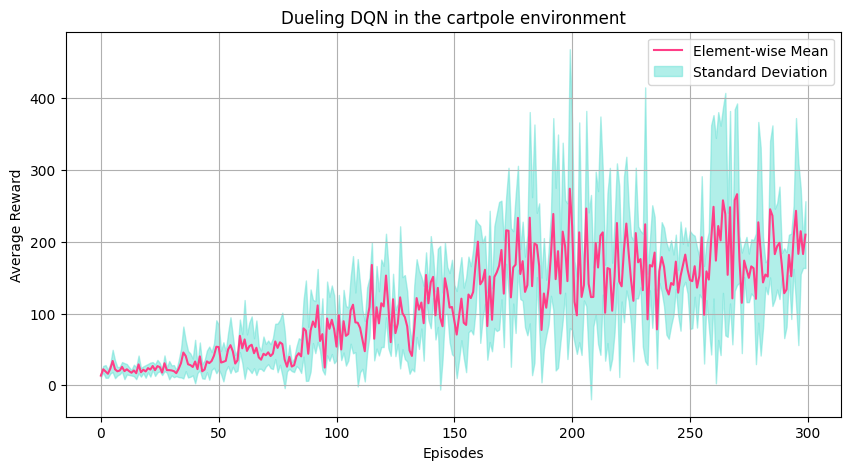

In [49]:
# #0.001 lr

# arraysNew_maxUpdate = allNew_scores.copy()
# mean_valuesNew_maxUpdate = np.mean(arraysNew_maxUpdate, axis=0)
# std_deviationNew_maxUpdate = np.std(arraysNew_maxUpdate, axis=0)

# # Plotting
# plt.figure(figsize=(10, 5))
# plt.plot(mean_valuesNew_maxUpdate, label='Element-wise Mean', color='#FF3E87')
# plt.fill_between(range(300), mean_valuesNew_maxUpdate - std_deviationNew_maxUpdate, mean_valuesNew_maxUpdate + std_deviationNew_maxUpdate, color='#64E0D5', alpha=0.5, label='Standard Deviation')
# plt.title('Dueling DQN in the cartpole environment - Type ')
# plt.xlabel('Episodes')
# plt.ylabel('Average Reward')
# plt.legend()
# plt.grid(True)
# plt.show()

In [57]:
# '''
# ### Q Network & Some 'hyperparameters'

# QNetwork1:
# Input Layer - 4 nodes (State Shape) \
# Hidden Layer 1 - 128 nodes \
# Hidden Layer 2 - 64 nodes \
# Output Layer - 2 nodes (Action Space) \
# Optimizer - zero_grad()
# '''

# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# '''
# Bunch of Hyper parameters (Which you might have to tune later)
# '''
# BUFFER_SIZE = int(1e6)  # replay buffer size
# HISTORY_SIZE = int(1000)
# FRACTION = 0.1
# BATCH_SIZE = 64         # minibatch size
# GAMMA = 0.99         # discount factor
# LR = 0.001               # learning rate
# UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


# # class QNetwork1(nn.Module):

# #     def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
# #         """Initialize parameters and build model.
# #         Params
# #         ======
# #             state_size (int): Dimension of each state
# #             action_size (int): Dimension of each action
# #             seed (int): Random seed
# #             fc1_units (int): Number of nodes in first hidden layer
# #             fc2_units (int): Number of nodes in second hidden layer
# #         """
# #         super(QNetwork1, self).__init__()
# #         self.seed = torch.manual_seed(seed)
# #         self.fc1 = nn.Linear(state_size, fc1_units)
# #         self.fc2 = nn.Linear(fc1_units, fc2_units)
# #         self.fc3 = nn.Linear(fc2_units, action_size)

# #     def forward(self, state):
# #         """Build a network that maps state -> action values."""
# #         x = F.relu(self.fc1(state))
# #         x = F.relu(self.fc2(x))
# #         return self.fc3(x)

# class DuelingQNetwork(nn.Module):
#     def __init__(self, state_size, action_size, seed,fc1_units=128, fc2_units=64):
#         super(DuelingQNetwork, self).__init__()
#         self.seed = torch.manual_seed(seed)
#         # # Define shared layers, state value stream, and advantage stream
#         self.fc1 = nn.Linear(state_size, fc1_units)
#         self.fc_value = nn.Linear(fc1_units, fc2_units)
#         self.fc_adv = nn.Linear(fc1_units, fc2_units)
#         self.value = nn.Linear(fc2_units, 1)
#         self.adv = nn.Linear(fc2_units, action_size)

#     def forward(self, state):
#         x = F.relu(self.fc1(state))
#         value = F.relu(self.fc_value(x))
#         adv = F.relu(self.fc_adv(x))
#         value = self.value(value)
#         adv = self.adv(adv)
#         debug = True
#         # while debug:
#         #   print(type(adv))
#         #   print(adv)
#         #   print(adv.shape)
#         #   debug = False
#         adv_average = torch.mean(adv, dim=1, keepdim=True)
#         #q = value + adv - adv_average
#         q = value + adv - torch.max(adv, dim = 1, keepdim = True)[0]
#         return q

# QNetwork1 = DuelingQNetwork

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100	Average Score: 38.86
Episode 200	Average Score: 100.16
Episode 300	Average Score: 101.04
Episode 100	Average Score: 40.80
Episode 200	Average Score: 103.72
Episode 300	Average Score: 113.23
Episode 100	Average Score: 37.06
Episode 200	Average Score: 123.99
Episode 300	Average Score: 76.11
Episode 100	Average Score: 41.05
Episode 200	Average Score: 107.83
Episode 300	Average Score: 142.89
Episode 100	Average Score: 40.47
Episode 200	Average Score: 92.25
Episode 300	Average Score: 101.66


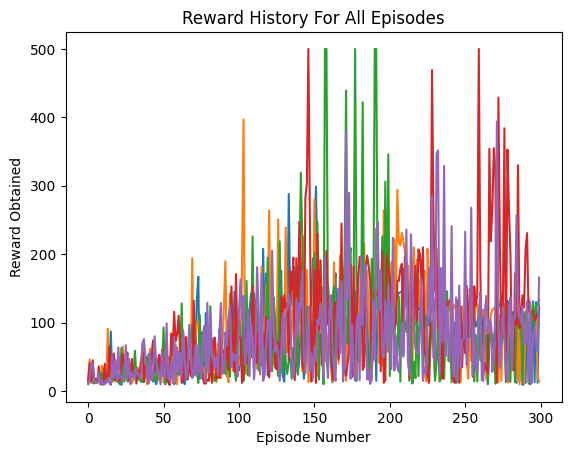

In [58]:
# allN1_scores = []
# seed = 0
# counter = 0
# while True:
#   np.random.seed(seed)
#   agent = TutorialAgent(state_shape, no_of_actions, seed)
#   scores, solved = dqn(policy="ep", n_episodes = 500)
#   allN1_scores.append(scores)
#   counter += 1
#   if counter >= 5:
#     break

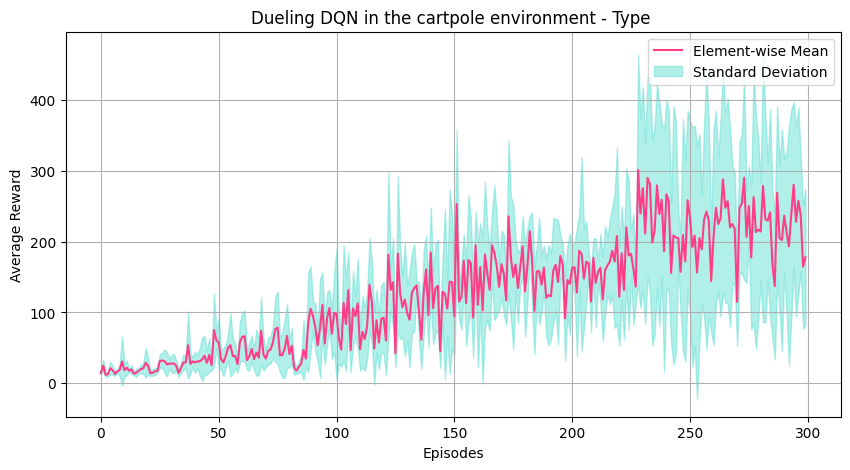

In [59]:
# #0.001 lr

# arraysNew1_maxUpdate = allNew_scores.copy()
# mean_valuesNew1_maxUpdate = np.mean(arraysNew1_maxUpdate, axis=0)
# std_deviationNew1_maxUpdate = np.std(arraysNew1_maxUpdate, axis=0)

# # Plotting
# plt.figure(figsize=(10, 5))
# plt.plot(mean_valuesNew1_maxUpdate, label='Element-wise Mean', color='#FF3E87')
# plt.fill_between(range(300), mean_valuesNew1_maxUpdate - std_deviationNew1_maxUpdate, mean_valuesNew1_maxUpdate + std_deviationNew1_maxUpdate, color='#64E0D5', alpha=0.5, label='Standard Deviation')
# plt.title('Dueling DQN in the cartpole environment - Type ')
# plt.xlabel('Episodes')
# plt.ylabel('Average Reward')
# plt.legend()
# plt.grid(True)
# plt.show()